In [32]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, f1_score
import nltk

import re
from nltk.tokenize import word_tokenize 
sns.set_theme()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [20]:
df= pd.read_csv('https://zenodo.org/record/5550238/files/osdg-community-dataset-v21-09-30.csv?download=1')
#keeping only the texts whose suggested sdg labels is accepted and the agreement score is at least .6
print('Shape before:', df.shape)
df = df.query('agreement >= .6 and labels_positive > labels_negative').copy()
print('Shape after :', df.shape)
display(df.head())

Shape before: (32121, 7)
Shape after : (17233, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
7,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000
8,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000
11,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,1.000000


In [21]:
from nltk.corpus import stopwords 
stopwords= stopwords.words('english')


def cleanText(text):
    text = re.sub(r'''!\(\)-\[]\{};:'"\,<>./?@#$%^&*_~''', r' ', text) 
    text = text.lower()
    text = text.replace(',', '')
    tokens = nltk.word_tokenize(text)
    wordlist = [] 
    for w in tokens:
      if w not in stopwords:
        if w.isalpha():
          wordlist.append(w)

    clean_text = ' '.join(wordlist)
    return clean_text
    
df['clean_text'] = df['text'].apply(cleanText)

In [22]:
def plot_confusion_matrix(y_true: np.ndarray, y_hat: np.ndarray, figsize = (20, 15)):
    # Getting labels
    labels = sorted(list(set(y_true)))
    
    # Creating confusion matrix
    df = pd.DataFrame(confusion_matrix(y_true, y_hat), index = labels, columns = labels)
    
    # Accuracy and F1-score
    acc = accuracy_score(y_true, y_hat)
    f1s = f1_score(y_true, y_hat, average = 'weighted')
    
    # Ploting Confusin matrix
    fig, ax = plt.subplots(figsize = figsize)
    sns.heatmap(df, annot = True, square = True, fmt = 'd', linewidths = 1,cbar = False, cmap = 'Paired', ax = ax)
    ax.set(title = f'Accuracy: {acc:.2f}, F1 score: {f1s:.2f}', xlabel = 'Predicted', ylabel = 'Actual')
    fig.suptitle('Confusion Matrix')
    plt.tight_layout()

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
X = df['clean_text']
y = df['sdg']
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['sdg'], test_size = .3, random_state = 42)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (12063,)
Test shape: (5170,)


In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
        penalty = 'l2',
        C = .9,
        multi_class = 'multinomial',
        class_weight = 'balanced',
        random_state = 29,
        solver = 'newton-cg',
        max_iter = 100
    )
pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(
        ngram_range = (1, 2),
        max_df = 0.75,
        min_df = 2,
        max_features = 100_000
    )),
    ('selector', SelectKBest(f_classif, k = 5_000)),
    ('clf', clf)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.75, max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('selector', SelectKBest(k=5000)),
                ('clf',
                 LogisticRegression(C=0.9, class_weight='balanced',
                                    multi_class='multinomial', random_state=29,
                                    solver='newton-cg'))])

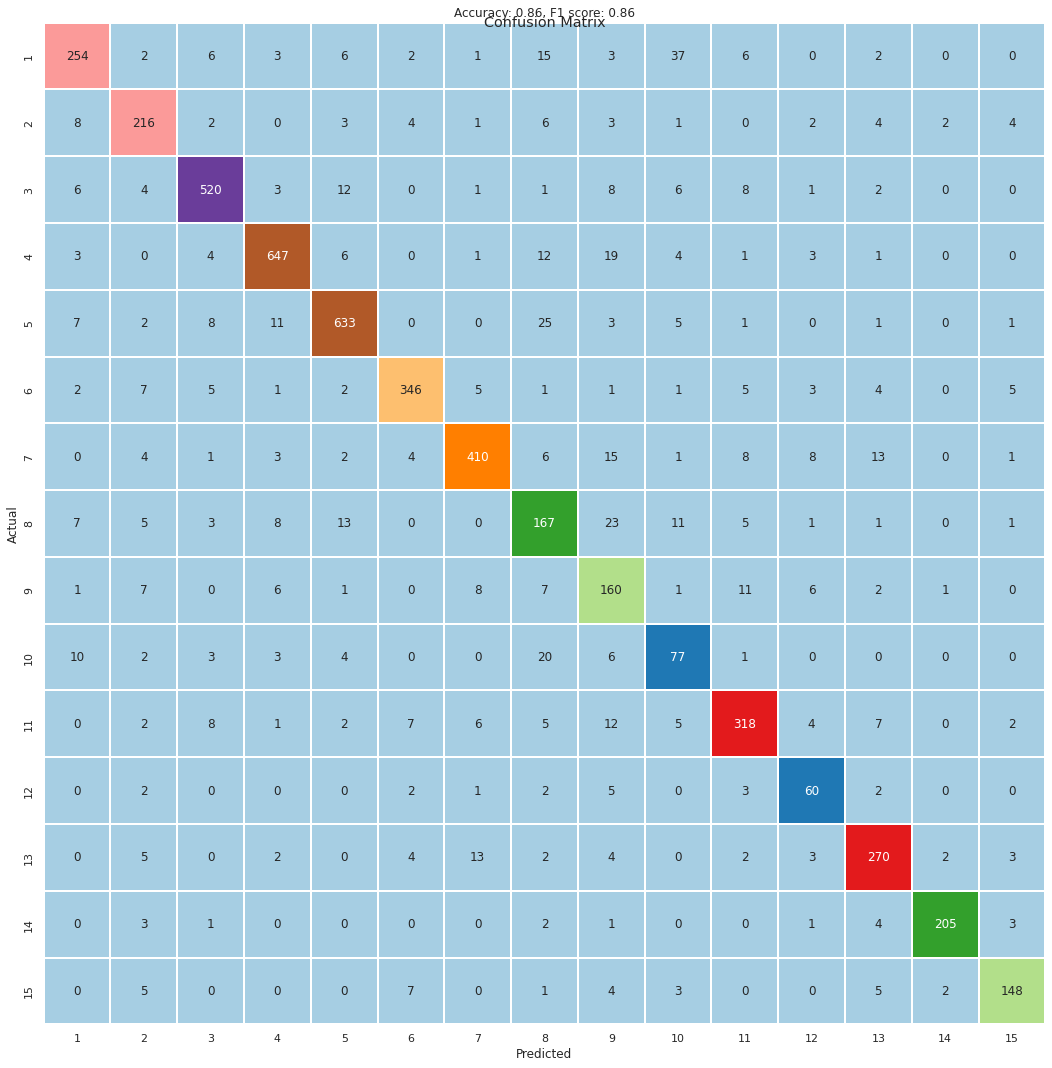

In [25]:
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

In [26]:
print(classification_report(y_test, y_hat, zero_division = 0))

              precision    recall  f1-score   support

           1       0.85      0.75      0.80       337
           2       0.81      0.84      0.83       256
           3       0.93      0.91      0.92       572
           4       0.94      0.92      0.93       701
           5       0.93      0.91      0.92       697
           6       0.92      0.89      0.91       388
           7       0.92      0.86      0.89       476
           8       0.61      0.68      0.65       245
           9       0.60      0.76      0.67       211
          10       0.51      0.61      0.55       126
          11       0.86      0.84      0.85       379
          12       0.65      0.78      0.71        77
          13       0.85      0.87      0.86       310
          14       0.97      0.93      0.95       220
          15       0.88      0.85      0.86       175

    accuracy                           0.86      5170
   macro avg       0.82      0.83      0.82      5170
weighted avg       0.86   

In [27]:
vectoriser = pipe['vectoriser']
selector = pipe['selector']
clf = pipe['clf']

top_n = 15
features =  pipe['vectoriser'].get_feature_names_out()
if selector is not None:
    features = features[selector.get_support()]
axis_names = [f'freature_{x + 1}' for x in range(top_n)]

if len(clf.classes_) > 2:
    results = list()
    for c, coefs in zip(clf.classes_, clf.coef_):
        idx = coefs.argsort()[::-1][:top_n]
        results.extend(tuple(zip([c] * top_n, features[idx], coefs[idx])))
else:
  coefs = clf.coef_.flatten()
  idx = coefs.argsort()[::-1][:top_n]
  results = tuple(zip([clf.classes_[1]] * top_n, features[idx], coefs[idx]))

df_lambda = pd.DataFrame(results, columns =  ['sdg', 'feature', 'coef'])
print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (225, 3)


,sdg,feature,coef
0,1,poverty,13.091357
1,1,poor,7.180285
2,1,income,4.733363
3,1,children,4.498303
4,1,deprivation,4.315738


In [28]:
import plotly.express as px

df_lambda.sort_values(['sdg', 'coef'], ignore_index = True, inplace = True)

colors = px.colors.qualitative.Dark24[:15]
template = 'SDG: %{customdata}<br>Feature: %{y}<br>Coefficient: %{x:.2f}'

fig = px.bar(
    data_frame = df_lambda,
    x = 'coef',
    y = 'feature',
    custom_data = ['sdg'],
    facet_col = 'sdg',
    facet_col_wrap = 3,
    #facet_col_spacing = .15,
    orientation = 'h',
    height = 1200,
    labels = {
        'coef': 'Coefficient',
        'feature': ''
    },
    title = 'Figure 3. Top 15 Strongest Predictors by SDG'
)

fig.for_each_trace(lambda x: x.update(hovertemplate = template))
fig.for_each_trace(lambda x: x.update(marker_color = colors.pop(0)))
fig.update_yaxes(matches = None, showticklabels = True)

fig.show()

In [33]:
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
import os
from datetime import datetime


def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text
    
#from google.colab import files
#uploaded = files.upload()
text = convert_pdf_to_txt('./Sai.pdf')
text = re.sub('\s+', ' ', text)
a = set(nltk.corpus.stopwords.words('english'))

text1 = nltk.word_tokenize(text.lower())
stopwords = [x for x in text1 if x not in a]
text = nltk.word_tokenize(" ".join(map(str, stopwords)))
finaltext = ''
for token in text:
    temp = nltk.pos_tag([token])
    if(nltk.pos_tag([token])[0][1] == 'JJ' or nltk.pos_tag([token])[0][1] == 'NN' or nltk.pos_tag([token])[0][1][0] == 'V'):
        finaltext += " "+nltk.pos_tag([token])[0][0]

In [34]:
import pickle
filename = 'model.sav'
pickle.dump(pipe, open(filename, 'wb'))

load_model = pickle.load(open(filename, 'rb'))

In [35]:
input = [finaltext]
load_model.predict(input)

array([12])

In [36]:
prediction = load_model.predict_proba(input)
prediction = prediction[0]
prediction

array([0.01396827, 0.01828276, 0.01403743, 0.02091588, 0.01635215,
       0.08293187, 0.05253623, 0.04547306, 0.05315607, 0.0134725 ,
       0.04291984, 0.53398778, 0.03437459, 0.02883717, 0.02875442])

Saving Sai.pdf to Sai.pdf


{'Sai.pdf': b'%PDF-1.7\r%\xe2\xe3\xcf\xd3\r\n107 0 obj\r<</Linearized 1/L 362706/O 109/E 209475/N 25/T 362257/H [ 495 275]>>\rendobj\r            \r\n123 0 obj\r<</DecodeParms<</Columns 5/Predictor 12>>/Filter/FlateDecode/ID[<B52415502649254C82A2BA2686002400><F0FB63C8466DD146918CF3BE5BEC922F>]/Index[107 31]/Info 106 0 R/Length 88/Prev 362258/Root 108 0 R/Size 138/Type/XRef/W[1 3 1]>>stream\r\nh\xdebbd`\x10``b``\xfe\x04"\x19\x82@$#7\x88d\xf9\x0c"\x99\xd2\xc0\xa4;X$\x14\xac\xf24\x98\xfc\t\x16\xbf\t\x16\x17\x06\x8bX\x83I\x0e\xb0\xf8\x17 \xc98\xbf\x1bH\xfe\xb7]\xc7\xc0\x04\xb4\xe5\x17\xd8|\x06F*\x90\xff\x19\x18\x1b\xbf\x00\x04\x18\x00\x7f\xaf\x0e0\r\nendstream\rendobj\rstartxref\r\n0\r\n%%EOF\r\n      \r\n137 0 obj\r<</Filter/FlateDecode/I 377/Length 186/S 299/V 355>>stream\r\nh\xdeb```f``rd`a`\x10\xe2c\x10b@\x00!\xa0\x0c\x0b\x10rl@\x12d8n\xe1\xc05\x81e\x07K.\xc31\x86\xc5\x05\xecgX\xa70\xecp\xd0q\x10N\xe1(c4<\x90pA\xe0\x01\x8b\x16\xc7\x89\x86\x85\x01\x92)\xccn\x8c\x17\x1a\xda\n\xc4>\x00\xb

In [30]:
#pip install pdfminer

     |████████████████████████████████| 4.2 MB 14.0 MB/s 
     |████████████████████████████████| 1.9 MB 41.3 MB/s 
  Created wheel for pdfminer: filename=pdfminer-20191125-py3-none-any.whl size=6140089 sha256=30dc64904bff4ae2c720934a66a2d32af8e81f5fc6d21fb27e29592282d32489
  Stored in directory: /root/.cache/pip/wheels/e3/5e/f4/d210b46e9e4a28229ea070ed5b3efa92c3c29d1a7918dd4b97
Successfully built pdfminer
